# benchmarking on sergio


In [26]:
from bengrn import BenGRN
import scanpy as sc

from scdataloader import Preprocessor

from anndata.utils import make_index_unique
from bengrn import compute_genie3
from grnndata import utils as grnutils
from grnndata import read_h5ad
import numpy as np
import pandas as pd

from scdataloader import utils as data_utils

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#genes = torch.load('/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', map_location=torch.device('cpu'))['hyper_parameters']['genes']

genes = torch.load('../data/temp/vbd8bavn/epoch=17-step=90000.ckpt')['hyper_parameters']['genes']

In [5]:
adata = sc.read_h5ad("../tools/SERGIO/sergio_gt_grn.h5ad")


In [6]:
adata

AnnData object with n_obs × n_vars = 1000 × 813
    obs: 'organism_ontology_term_id'
    var: 'biotype', 'description', 'ensembl_gene_id', 'mt', 'ncbi_gene_ids', 'organism_id', 'symbol', 'synonyms', 'uid'

In [8]:
adata = sc.read_h5ad("../tools/SERGIO/sergio_gt_grn.h5ad")
adata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
genesdf = data_utils.load_genes(adata.obs.organism_ontology_term_id.iloc[0])
adata

AnnData object with n_obs × n_vars = 1000 × 813
    obs: 'organism_ontology_term_id'
    varp: 'GRN'

In [9]:
# Merge adata.var with genesdf
# First, ensure the index of adata.var is named
adata.var.index.name = 'symbol'

# Merge adata.var with genesdf
# Merge adata.var with genesdf, keeping only the first instance of each symbol
merged_var = adata.var.reset_index().merge(
    genesdf.reset_index().drop_duplicates(subset='symbol', keep='first'),
    left_on='symbol',
    right_on='symbol',
    how='left'
)

# Set the index back to 'symbol'
merged_var.set_index('symbol', inplace=True)
adata.var = merged_var
adata.var['symbol'] =  adata.var.index

In [10]:
subadata = adata[:, adata.var.ensembl_gene_id.isin(genes)].copy()
del subadata.varp['GRN']

In [13]:
from grnndata import GRNAnnData

import sys
sys.path.append("../tools/DeepSEM")

from src.DeepSEM_cell_type_test_specific_GRN_model import celltype_GRN_model as test_celltype_GRN_model

class DotDict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


def run_deepsem(adata):
    import random
    import string

    def generate_random_hash(length=3):
        """Generate a random hash of specified length."""
        characters = string.ascii_letters + string.digits
        return ''.join(random.choice(characters) for _ in range(length))

    random_hash = generate_random_hash()
    opt = DotDict({
        'beta': 0.01,
        'alpha': 1,
        'K1': 1,
        'K2': 2,
        'K': 1,
        'net_file': "",
        'n_epochs': 50,
        'n_hidden': 128,
        'gamma': 0.95,
        'lr': 1e-4,
        'lr_step_size': 0.99,
        'batch_size': 64,
        'data_file': "/tmp/deepsem_"+random_hash+".h5ad",
        'save_name': "/tmp/deepsem/",
        'task': "celltype_GRN"
    })
    print(random_hash)
    adata.write("/tmp/deepsem_"+random_hash+".h5ad")
    model = test_celltype_GRN_model(opt)
    net = model.train_model()
    grn = GRNAnnData(adata.copy(), grn=net)
    del net
    return grn

In [16]:
subadata.var.drop(columns=['mt', 'ribo', 'hb'], inplace=True)

In [17]:
# normal
genie_grn = run_deepsem(subadata)
genie_grn.var.index = subadata.var.index

EGA
save dir exist


/home/ml4ig1/Documents code/scPRINT/notebooks/../tools/DeepSEM/src/DeepSEM_cell_type_test_specific_GRN_model.py:55: RuntimeWarning: divide by zero encountered in divide
  data_values = (data_values - means) / (stds)
/home/ml4ig1/Documents code/scPRINT/notebooks/../tools/DeepSEM/src/DeepSEM_cell_type_test_specific_GRN_model.py:55: RuntimeWarning: invalid value encountered in divide
  data_values = (data_values - means) / (stds)
/home/ml4ig1/Documents code/scPRINT/notebooks/../tools/DeepSEM/src/Model.py:194: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  adj_normalized = Tensor(np.eye(adj.shape[0])) - (adj.transpose(0, 1))


epoch: 1 0.5463392566889524 mse_loss: 0.5141883138567209 kl_loss: 0.030540395295247436 sparse_loss: 0.0016105388494906947
epoch: 2 0.5344421733170748 mse_loss: 0.5013462230563164 kl_loss: 0.03136561601422727 sparse_loss: 0.0017303225395153277
epoch: 4 0.13051284989342093 mse_loss: 0.08920593280345201 kl_loss: 0.03946375596569851 sparse_loss: 0.0018431601856718771
epoch: 5 0.125690130982548 mse_loss: 0.08151221089065075 kl_loss: 0.04223232192452997 sparse_loss: 0.0019455991059658118
epoch: 7 0.10165522107854486 mse_loss: 0.05740488902665675 kl_loss: 0.04225876636337489 sparse_loss: 0.0019915674201911315
epoch: 8 0.10147817572578788 mse_loss: 0.05644439975731075 kl_loss: 0.04301729390863329 sparse_loss: 0.002016484082560055
epoch: 10 0.09103273414075375 mse_loss: 0.04724215157330036 kl_loss: 0.04175740631762892 sparse_loss: 0.002033177443081513
epoch: 11 0.09246265795081854 mse_loss: 0.04832538077607751 kl_loss: 0.0420914301648736 sparse_loss: 0.002045847926638089
epoch: 13 0.08508151210

AttributeError: 'AnnData' object has no attribute 'grn'

In [22]:
adata = GRNAnnData(adata, grn=adata.varp['GRN'])

precision:  0.03244606491102127 
recall:  0.998546511627907 
random precision: 0.0324932935353459


  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 2066.71it/s]

Average Precision (AP):  0.031155614301563814
Area Under Precision-Recall Curve (AUPRC):  0.031143311412627255
EPR: 0.7296623818963998


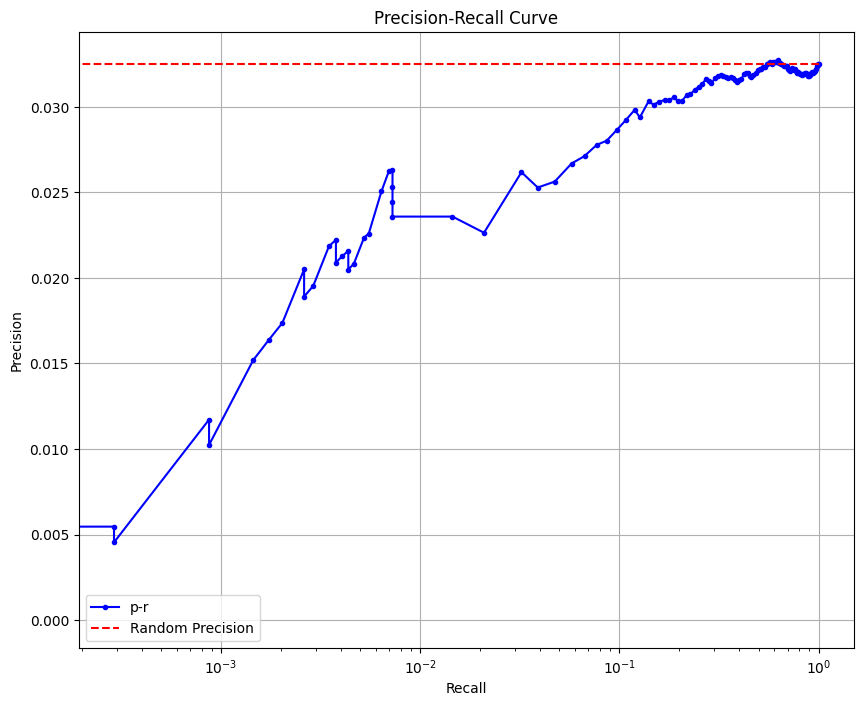

{'precision': 0.03244606491102127,
 'recall': 0.998546511627907,
 'rand_precision': 0.0324932935353459,
 'auprc': 0.031143311412627255,
 'ap': 0.031155614301563814,
 'epr': 0.7296623818963998}

In [23]:
BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=adata)

base enrichment
Top central genes: []


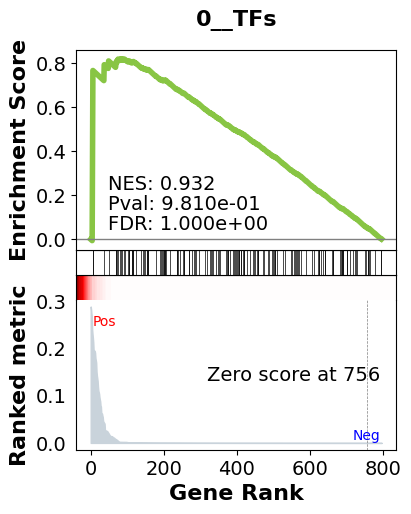

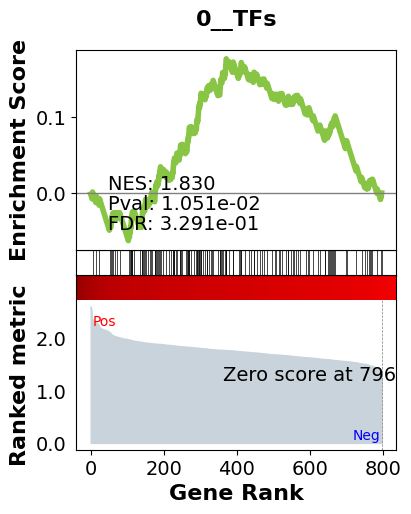

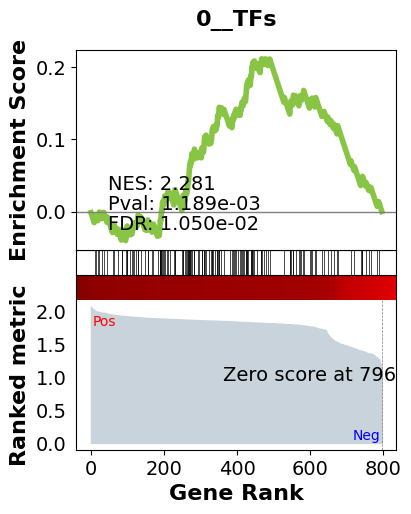

_________________________________________
TF specific enrichment
found some significant results for  7.894736842105263 % TFs

_________________________________________
loading GT,  omnipath
intersection of 652 genes
intersection pct: 0.8180677540777918
precision:  0.02473071159989822 
recall:  0.9999047437607164 
random precision: 0.024733067578901737


 86%|████████▌ | 110/128 [00:00<00:00, 544.73it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 518.08it/s]


Average Precision (AP):  0.025091582389353547
Area Under Precision-Recall Curve (AUPRC):  0.025074877524701264
EPR: 0.8048746007566698


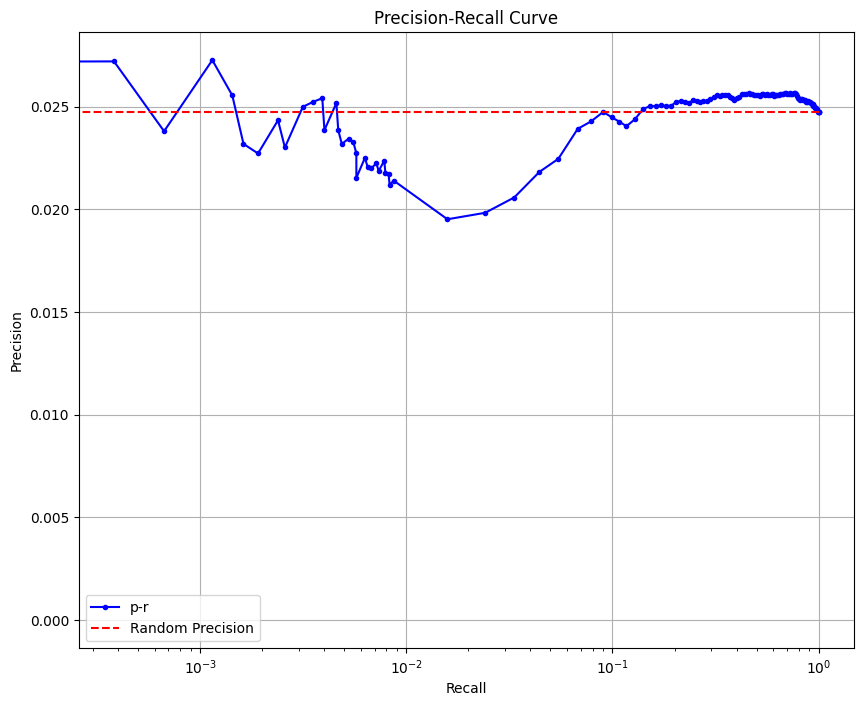

{'TF_enr': True,
 'enriched_terms_Targets': ['0__TFs'],
 'significant_enriched_TFtargets': 7.894736842105263,
 'precision': 0.02473071159989822,
 'recall': 0.9999047437607164,
 'rand_precision': 0.024733067578901737,
 'auprc': 0.025074877524701264,
 'ap': 0.025091582389353547,
 'epr': 0.8048746007566698}

In [25]:
genie_grn.var.index = make_index_unique(genie_grn.var['symbol'].astype(str))
BenGRN(genie_grn).scprint_benchmark()